In [69]:
# imports
import h5py
import numpy as np
import allel
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA

In [32]:
# load the hdf5 file
tgp_MCM_data = h5py.File('data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5', mode='r')
# extract genotypes
tgp_MCM_gt = allel.GenotypeArray(tgp_MCM_data['all/calldata/GT'][:])

# extract the variable positions array
tgp_MCM_pos = allel.SortedIndex(tgp_MCM_data['all/variants/POS'][:])
# extract the samples array
tgp_MCM_samps = np.array([samp.decode() for samp in tgp_MCM_data['all/samples'][:]])


In [ ]:
# load the hdf5 file
tgp_LCT_data = h5py.File('data/tgp_var_sites_no_aa_calls_chr2_LCT.h5', mode='r')
# extract genotypes
tgp_LCT_gt = allel.GenotypeArray(tgp_LCT_data['calldata/GT'][:])
# extract the variable positions array
tgp_LCT_pos = allel.SortedIndex(tgp_LCT_data['variants/POS'][:])
# extract the samples array
tgp_LCT_samps = np.array([samp.decode() for samp in tgp_LCT_data['samples'][:]])
tgp_LCT_data['calldata/GT']

(1377, 2504, 2)


<HDF5 dataset "GT": shape (1377, 2504, 2), type "|i1">

In [ ]:
metadata = pd.read_csv("data/tgp_meta_info.txt", 
                       header=None, 
                       names=["sample", "population", "super_population"],
                       sep='\t')
samples_df = pd.DataFrame({"sample": tgp_LCT_samps})

merged = samples_df.merge(
    metadata[["sample","population","super_population"]],
    on="sample",
    how="left"
)
print(merged.head())

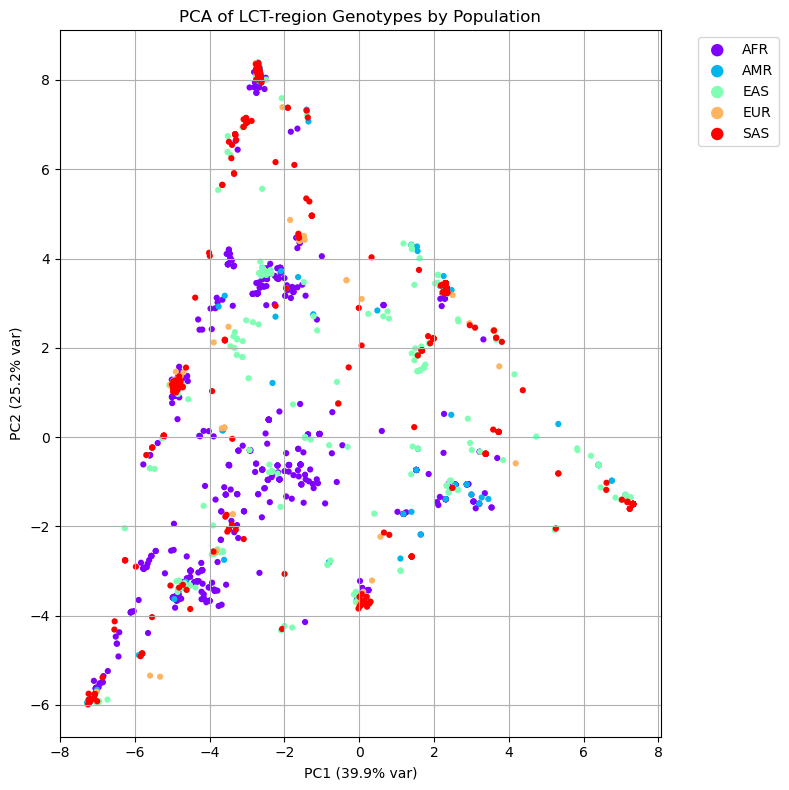

In [ ]:
pops = merged["super_population"].values

gt = tgp_LCT_gt[:]            # (V, N, 2)
ac = gt.sum(axis=2)           # (V, N)
geno = ac.T                   # (N, V)
pca = PCA(n_components=2)
coords = pca.fit_transform(geno)

# get the unique populations and a qualitative colormap
unique_pops = np.unique(pops)
cmap = plt.get_cmap("rainbow", len(unique_pops))

plt.figure(figsize=(8,8))
for i, pop in enumerate(unique_pops):
    mask = (pops == pop)
    plt.scatter(
        coords[mask, 0],
        coords[mask, 1],
        s=20,
        color=cmap(i),
        label=pop,
        edgecolor="none"
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of LCT-region Genotypes by Population")
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


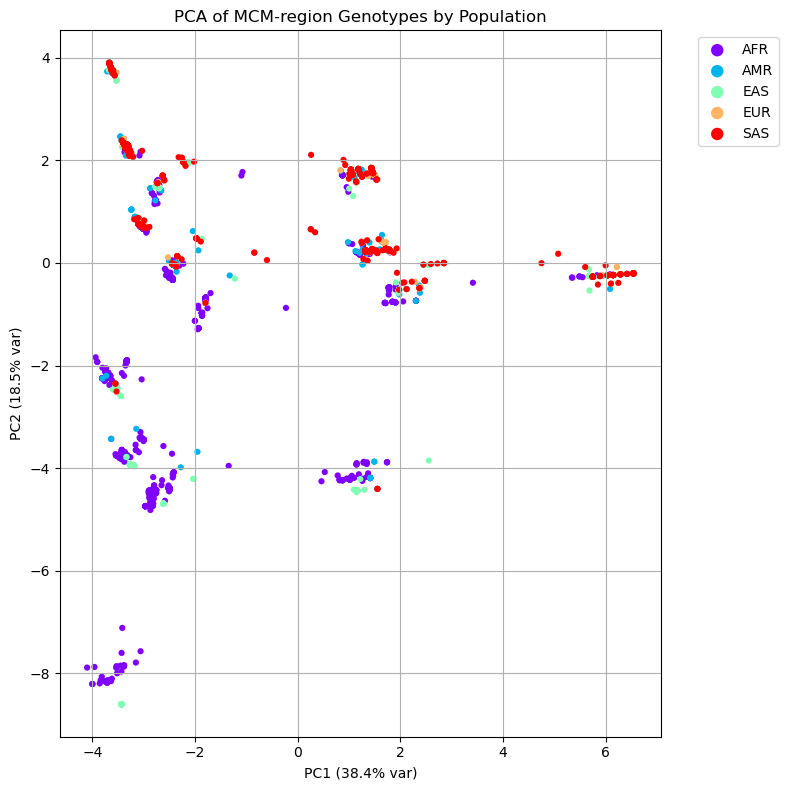

In [71]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# your merged DataFrame already has a “population” column aligned with tgp_LCT_samps
pops = merged["super_population"].values

# build the genotype matrix and run PCA (same as before)
gt = tgp_MCM_gt[:]            # (V, N, 2)
ac = gt.sum(axis=2)           # (V, N)
geno = ac.T                   # (N, V)
pca = PCA(n_components=2)
coords = pca.fit_transform(geno)

# get the unique populations and a qualitative colormap
unique_pops = np.unique(pops)
cmap = plt.get_cmap("rainbow", len(unique_pops))

plt.figure(figsize=(8,8))
for i, pop in enumerate(unique_pops):
    mask = (pops == pop)
    plt.scatter(
        coords[mask, 0],
        coords[mask, 1],
        s=20,
        color=cmap(i),
        label=pop,
        edgecolor="none"
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of MCM-region Genotypes by Population")
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


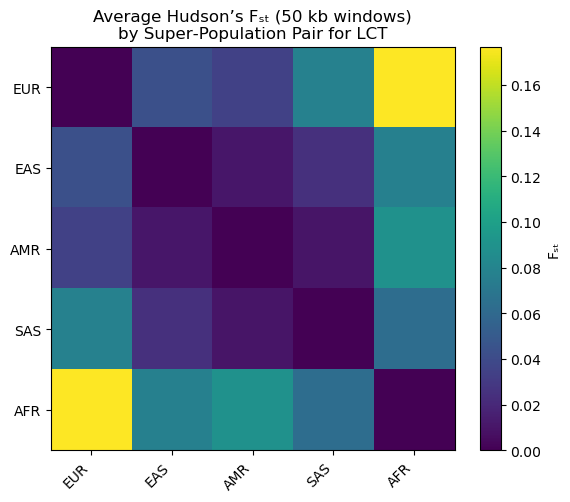

In [73]:
fn = 'data/tgp_var_sites_no_aa_calls_chr2_LCT.h5'
with h5py.File(fn, 'r') as f:
    gt = allel.GenotypeArray(f['all/calldata/GT'][:])
    pos = allel.SortedIndex(f['all/variants/POS'][:])
    samples = np.array([s.decode() for s in f['all/samples'][:]])

meta = pd.read_csv(
    "data/tgp_meta_info.txt",
    sep='\t',
    header=None,
    names=["sample", "population", "super_population"]
)
df = pd.DataFrame({'sample': samples})
df = df.merge(meta, on='sample', how='left')

super_pops = df['super_population'].unique()
pop_idx = {
    pop: np.where(df['super_population'] == pop)[0]
    for pop in super_pops
}

ac_all = gt.count_alleles()
maf = np.minimum(ac_all[:,0], ac_all[:,1]) / ac_all.sum(axis=1)
keep = maf >= 0.05
gt = gt.compress(keep, axis=0)
pos = pos[keep]

wsize = 50_000
start, stop = pos.min(), pos.max()
bins = np.arange(start, stop + wsize, wsize)
n_win = len(bins) - 1

pairs = list(combinations(super_pops, 2))
fst_sq = np.zeros((len(super_pops), len(super_pops)), dtype=float)
for pop1, pop2 in pairs:
    i = np.where(super_pops == pop1)[0][0]
    j = np.where(super_pops == pop2)[0][0]

    ac1 = gt.take(pop_idx[pop1], axis=1).count_alleles()
    ac2 = gt.take(pop_idx[pop2], axis=1).count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)

    widx = np.digitize(pos, bins) - 1  
    
    num_w = np.bincount(widx, weights=num, minlength=n_win)
    den_w = np.bincount(widx, weights=den, minlength=n_win)
    with np.errstate(invalid='ignore', divide='ignore'):
        fst_win = num_w / den_w
    fst_mean = np.nanmean(fst_win)

    fst_sq[i, j] = fst_sq[j, i] = fst_mean

np.fill_diagonal(fst_sq, 0.0)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(fst_sq, vmin=0, vmax=fst_sq.max(), cmap='viridis')
ax.set_xticks(np.arange(len(super_pops)))
ax.set_yticks(np.arange(len(super_pops)))
ax.set_xticklabels(super_pops, rotation=45, ha='right')
ax.set_yticklabels(super_pops)
ax.set_title("Average Hudson’s Fₛₜ (50 kb windows)\nby Super‐Population Pair for LCT")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fₛₜ")
plt.tight_layout()
plt.show()

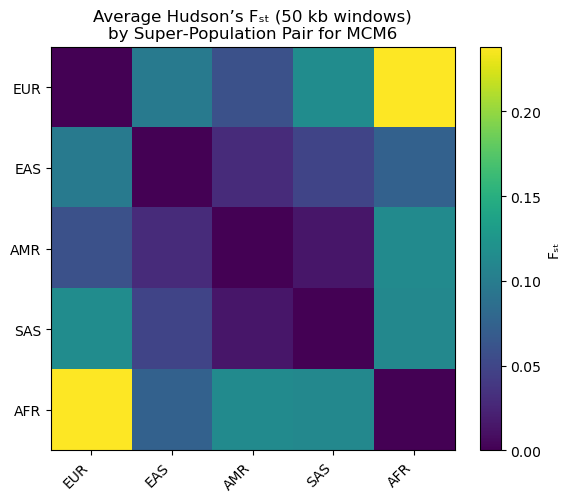

In [77]:
fn = 'data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5'
with h5py.File(fn, 'r') as f:
    gt = allel.GenotypeArray(f['all/calldata/GT'][:])
    pos = allel.SortedIndex(f['all/variants/POS'][:])
    samples = np.array([s.decode() for s in f['all/samples'][:]])

meta = pd.read_csv(
    "data/tgp_meta_info.txt",
    sep='\t',
    header=None,
    names=["sample", "population", "super_population"]
)
df = pd.DataFrame({'sample': samples})
df = df.merge(meta, on='sample', how='left')

super_pops = df['super_population'].unique()
pop_idx = {
    pop: np.where(df['super_population'] == pop)[0]
    for pop in super_pops
}

ac_all = gt.count_alleles()
maf = np.minimum(ac_all[:,0], ac_all[:,1]) / ac_all.sum(axis=1)
keep = maf >= 0.05
gt = gt.compress(keep, axis=0)
pos = pos[keep]

wsize = 50_000
start, stop = pos.min(), pos.max()
bins = np.arange(start, stop + wsize, wsize)
n_win = len(bins) - 1

pairs = list(combinations(super_pops, 2))
fst_sq = np.zeros((len(super_pops), len(super_pops)), dtype=float)
for pop1, pop2 in pairs:
    i = np.where(super_pops == pop1)[0][0]
    j = np.where(super_pops == pop2)[0][0]

    ac1 = gt.take(pop_idx[pop1], axis=1).count_alleles()
    ac2 = gt.take(pop_idx[pop2], axis=1).count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)

    widx = np.digitize(pos, bins) - 1  
    
    num_w = np.bincount(widx, weights=num, minlength=n_win)
    den_w = np.bincount(widx, weights=den, minlength=n_win)
    with np.errstate(invalid='ignore', divide='ignore'):
        fst_win = num_w / den_w
    fst_mean = np.nanmean(fst_win)

    fst_sq[i, j] = fst_sq[j, i] = fst_mean

np.fill_diagonal(fst_sq, 0.0)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(fst_sq, vmin=0, vmax=fst_sq.max(), cmap='viridis')
ax.set_xticks(np.arange(len(super_pops)))
ax.set_yticks(np.arange(len(super_pops)))
ax.set_xticklabels(super_pops, rotation=45, ha='right')
ax.set_yticklabels(super_pops)
ax.set_title("Average Hudson’s Fₛₜ (50 kb windows)\nby Super‐Population Pair for MCM6")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fₛₜ")
plt.tight_layout()
plt.show()

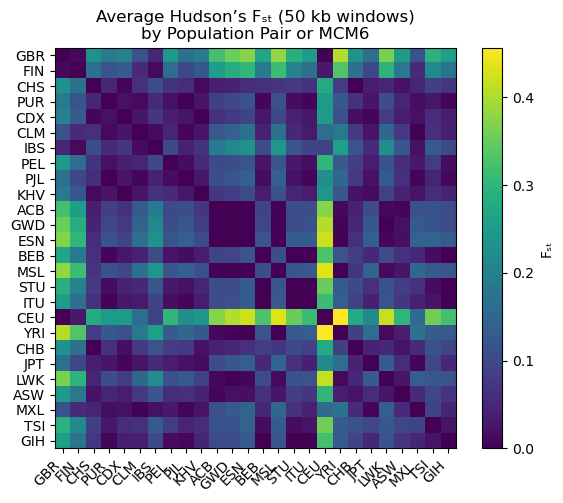

In [74]:
fn = 'data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5'
with h5py.File(fn, 'r') as f:
    gt = allel.GenotypeArray(f['all/calldata/GT'][:])
    pos = allel.SortedIndex(f['all/variants/POS'][:])
    samples = np.array([s.decode() for s in f['all/samples'][:]])

meta = pd.read_csv(
    "data/tgp_meta_info.txt",
    sep='\t',
    header=None,
    names=["sample", "population", "super_population"]
)
df = pd.DataFrame({'sample': samples})
df = df.merge(meta, on='sample', how='left')

super_pops = df['population'].unique()
pop_idx = {
    pop: np.where(df['population'] == pop)[0]
    for pop in super_pops
}

ac_all = gt.count_alleles()
maf = np.minimum(ac_all[:,0], ac_all[:,1]) / ac_all.sum(axis=1)
keep = maf >= 0.05
gt = gt.compress(keep, axis=0)
pos = pos[keep]

wsize = 50_000
start, stop = pos.min(), pos.max()
bins = np.arange(start, stop + wsize, wsize)
n_win = len(bins) - 1

pairs = list(combinations(super_pops, 2))
fst_sq = np.zeros((len(super_pops), len(super_pops)), dtype=float)
for pop1, pop2 in pairs:
    i = np.where(super_pops == pop1)[0][0]
    j = np.where(super_pops == pop2)[0][0]

    ac1 = gt.take(pop_idx[pop1], axis=1).count_alleles()
    ac2 = gt.take(pop_idx[pop2], axis=1).count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)

    widx = np.digitize(pos, bins) - 1  
    
    num_w = np.bincount(widx, weights=num, minlength=n_win)
    den_w = np.bincount(widx, weights=den, minlength=n_win)
    with np.errstate(invalid='ignore', divide='ignore'):
        fst_win = num_w / den_w
    fst_mean = np.nanmean(fst_win)

    fst_sq[i, j] = fst_sq[j, i] = fst_mean

np.fill_diagonal(fst_sq, 0.0)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(fst_sq, vmin=0, vmax=fst_sq.max(), cmap='viridis')
ax.set_xticks(np.arange(len(super_pops)))
ax.set_yticks(np.arange(len(super_pops)))
ax.set_xticklabels(super_pops, rotation=45, ha='right')
ax.set_yticklabels(super_pops)
ax.set_title("Average Hudson’s Fₛₜ (50 kb windows)\nby Population Pair for MCM6")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fₛₜ")
plt.tight_layout()
plt.show()

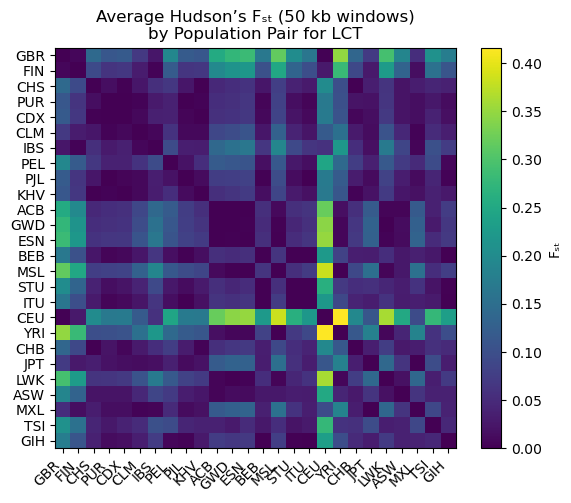

In [79]:
fn = 'data/tgp_var_sites_no_aa_calls_chr2_LCT.h5'
with h5py.File(fn, 'r') as f:
    gt = allel.GenotypeArray(f['all/calldata/GT'][:])
    pos = allel.SortedIndex(f['all/variants/POS'][:])
    samples = np.array([s.decode() for s in f['all/samples'][:]])

meta = pd.read_csv(
    "data/tgp_meta_info.txt",
    sep='\t',
    header=None,
    names=["sample", "population", "super_population"]
)
df = pd.DataFrame({'sample': samples})
df = df.merge(meta, on='sample', how='left')

super_pops = df['population'].unique()
pop_idx = {
    pop: np.where(df['population'] == pop)[0]
    for pop in super_pops
}

ac_all = gt.count_alleles()
maf = np.minimum(ac_all[:,0], ac_all[:,1]) / ac_all.sum(axis=1)
keep = maf >= 0.05
gt = gt.compress(keep, axis=0)
pos = pos[keep]

wsize = 50_000
start, stop = pos.min(), pos.max()
bins = np.arange(start, stop + wsize, wsize)
n_win = len(bins) - 1

pairs = list(combinations(super_pops, 2))
fst_sq = np.zeros((len(super_pops), len(super_pops)), dtype=float)
for pop1, pop2 in pairs:
    i = np.where(super_pops == pop1)[0][0]
    j = np.where(super_pops == pop2)[0][0]

    ac1 = gt.take(pop_idx[pop1], axis=1).count_alleles()
    ac2 = gt.take(pop_idx[pop2], axis=1).count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)

    widx = np.digitize(pos, bins) - 1  
    
    num_w = np.bincount(widx, weights=num, minlength=n_win)
    den_w = np.bincount(widx, weights=den, minlength=n_win)
    with np.errstate(invalid='ignore', divide='ignore'):
        fst_win = num_w / den_w
    fst_mean = np.nanmean(fst_win)

    fst_sq[i, j] = fst_sq[j, i] = fst_mean

np.fill_diagonal(fst_sq, 0.0)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(fst_sq, vmin=0, vmax=fst_sq.max(), cmap='viridis')
ax.set_xticks(np.arange(len(super_pops)))
ax.set_yticks(np.arange(len(super_pops)))
ax.set_xticklabels(super_pops, rotation=45, ha='right')
ax.set_yticklabels(super_pops)
ax.set_title("Average Hudson’s Fₛₜ (50 kb windows)\nby Population Pair for LCT")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fₛₜ")
plt.tight_layout()
fig.savefig('figures/LCT_FST_populations.png', dpi=300)
plt.show()

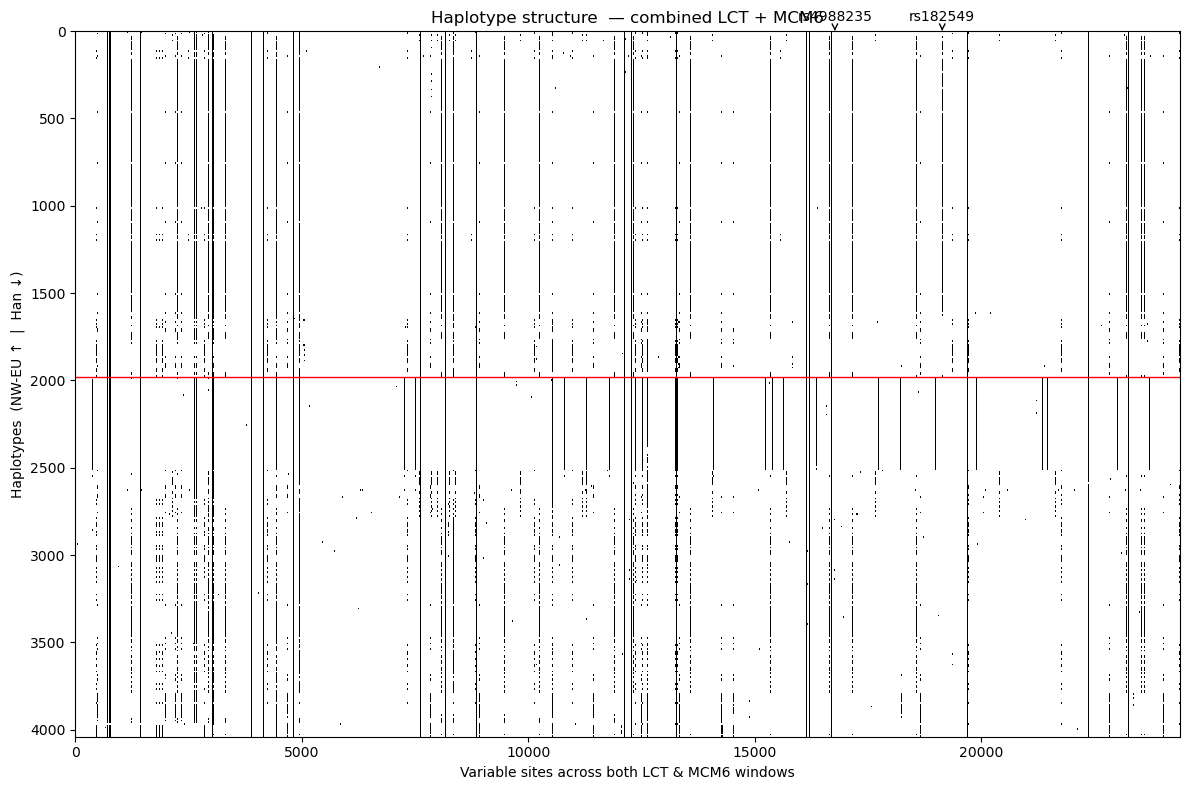

In [38]:
import h5py, numpy as np, pandas as pd, matplotlib.pyplot as plt

files = {
    "LCT":  "data/tgp_var_sites_no_aa_calls_chr2_LCT.h5",
    "MCM6": "data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5",
}

haps_list = []
pos_list  = []
sams_ref  = None


for region, path in files.items():
    with h5py.File(path,'r') as h:
        gt   = h['all/calldata/GT'][:]
        pos  = h['all/variants/POS'][:]
        sams = np.array([x.decode() for x in h['all/samples'][:]])
        
    if sams_ref is None:
        sams_ref = sams
    else:
        if not np.array_equal(sams_ref, sams):
            raise ValueError(f"Sample order mismatch in {region}")
        
    V, S, _ = gt.shape
    hap = gt.reshape(V, S*2)
    hap = np.where(hap<0, 0, hap)
    haps_list.append(hap)
    pos_list.append(pos)

haps_all = np.vstack(haps_list)
pos_all  = np.concatenate(pos_list)

# ─── Identify CEU vs CHB haplotype columns ────────────────────────────────────
metadata = pd.read_csv("data/tgp_meta_info.txt", sep='\t', header=None,
                       names=["sample","population","super_population"])
samples_df = pd.DataFrame({"sample": sams_ref})
merged     = samples_df.merge(metadata, on="sample", how="left")

nw_idx  = merged.index[ merged['population']=="CEU" ].to_numpy()
han_idx = merged.index[ merged['population']=="CHB" ].to_numpy()

hap_cols = np.arange(len(sams_ref)*2).reshape(len(sams_ref), 2)
nw_cols  = hap_cols[nw_idx].ravel()
han_cols = hap_cols[han_idx].ravel()

nw_haps  = haps_all[:, nw_cols]
han_haps = haps_all[:, han_cols]

# ─── Order haplotypes by frequency ──────────────────────────────────────────
ord_nw   = np.argsort(nw_haps.sum(axis=0))[::-1]
ord_han  = np.argsort(han_haps.sum(axis=0))[::-1]
nw_haps  = nw_haps[:, ord_nw]
han_haps = han_haps[:, ord_han]

# ─── Stack and up-sample ─────────────────────────────────────────────────────
panel    = np.vstack([nw_haps.T, han_haps.T])  # shape (n_haps, n_sites)

scale    = 10
panel_big = np.repeat(np.repeat(panel, scale, axis=0), scale, axis=1)

# ─── Plot ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(panel_big,
          cmap='Greys',
          interpolation='none',
          aspect='auto')

# red line between CEU and CHB, scaled
boundary = nw_haps.shape[1]*scale - 0.5
ax.axhline(boundary, color='red', lw=1)

lp_snps = {
    'rs182549':    136616754,  # Chr2:136616754 (IVS9 G>A) :contentReference[oaicite:0]{index=0}
    'rs4988235':   136608646,  # Chr2:136608646 (−13910 C>T) :contentReference[oaicite:1]{index=1}
}

# annotate LP SNPs (y in fraction coords remains 1)
for name, snp_pos in lp_snps.items():
    if snp_pos in pos_all:
        idx = np.where(pos_all == snp_pos)[0][0]
        ax.annotate(name,
                    xy=(idx*scale, 1),
                    xycoords=('data','axes fraction'),
                    xytext=(0,5),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    arrowprops=dict(arrowstyle='->'),
                    clip_on=False)

ax.set_xlabel('Variable sites across both LCT & MCM6 windows')
ax.set_ylabel('Haplotypes  (NW-EU ↑  |  Han ↓)')
ax.set_title('Haplotype structure  — combined LCT + MCM6')
plt.tight_layout()
plt.show()


99 103


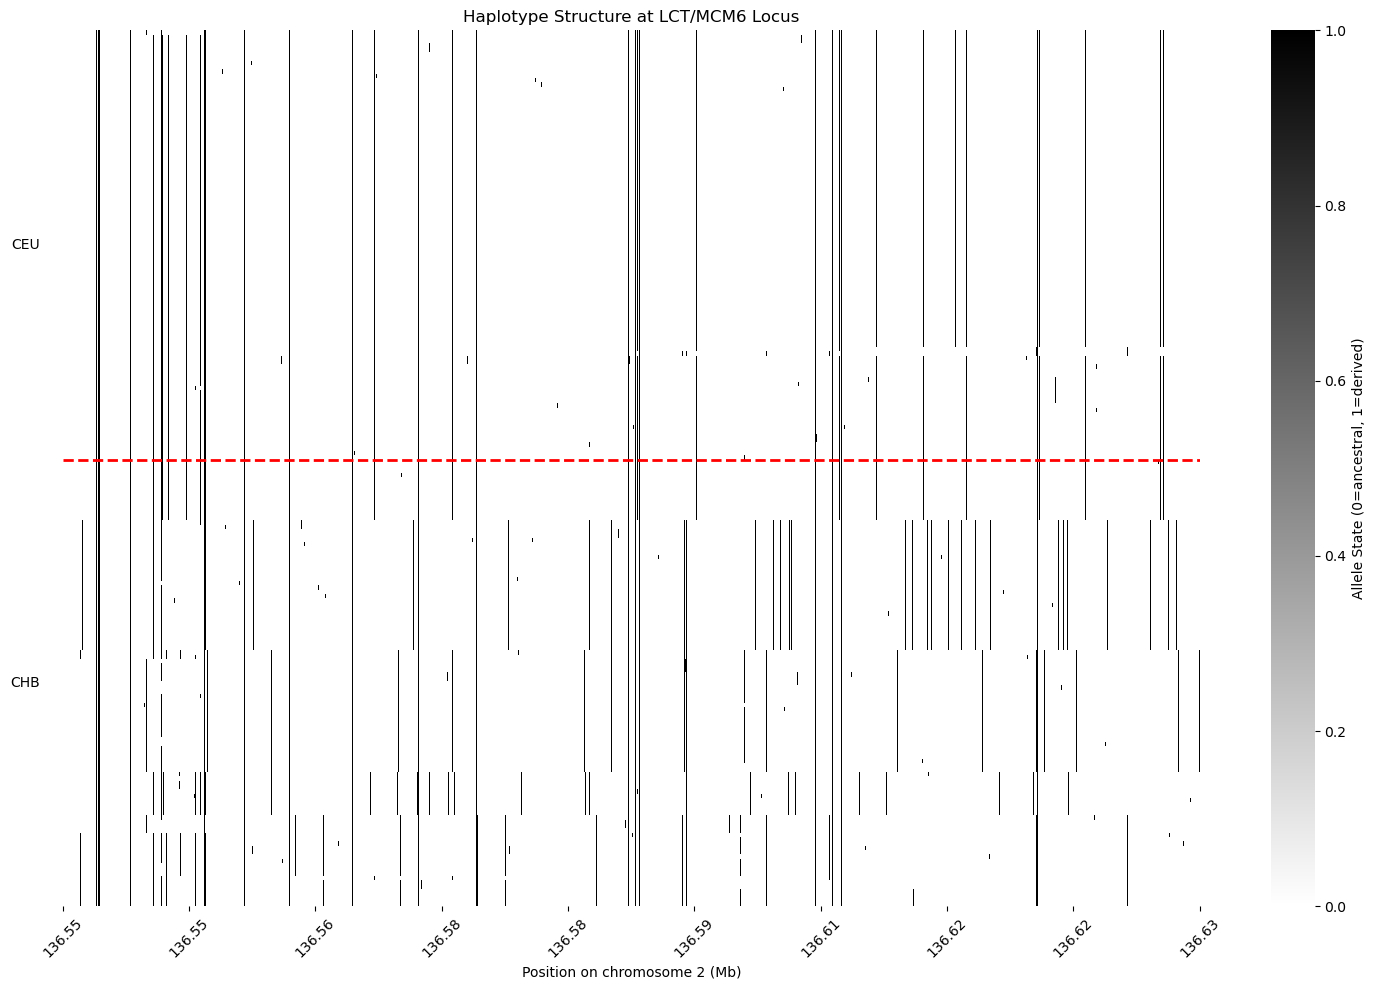

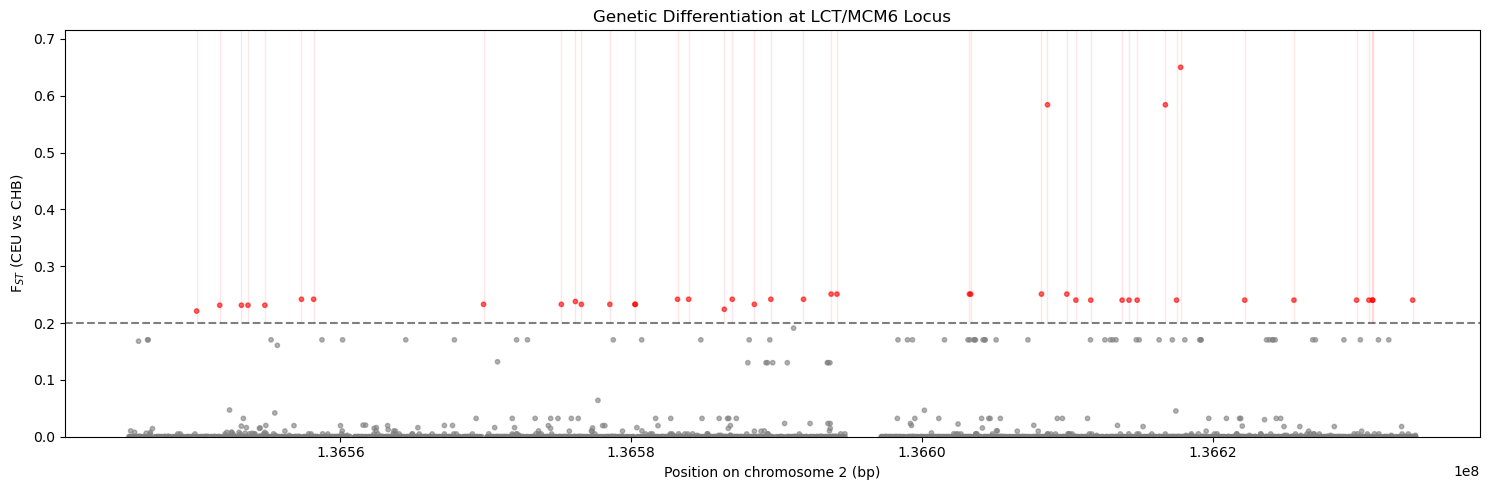

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns

# Load data from HDF5 files
files = {
    "LCT": "data/tgp_var_sites_no_aa_calls_chr2_LCT.h5",
    "MCM6": "data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5"
}

haps_list = []
pos_list = []
sams_ref = None

for region, path in files.items():
    with h5py.File(path, 'r') as h:
        gt = h['all/calldata/GT'][:]
        pos = h['all/variants/POS'][:]
        sams = np.array([x.decode() for x in h['all/samples'][:]])
        
    if sams_ref is None:
        sams_ref = sams
    else:
        assert np.array_equal(sams_ref, sams), "Sample mismatch between files"
        
    V, S, _ = gt.shape
    hap = gt.reshape(V, S*2)
    hap = np.where(hap < 0, 0, hap)
    haps_list.append(hap)
    pos_list.append(pos)

haps_all = np.vstack(haps_list)
pos_all = np.concatenate(pos_list)

# Identify population indices
metadata = pd.read_csv("data/tgp_meta_info.txt", sep='\t', 
                      names=["sample","population","super_population"])
samples_df = pd.DataFrame({"sample": sams_ref})
merged = samples_df.merge(metadata, on="sample", how="left")

# Get column indices for populations
nw_idx = merged.index[merged['population'] == "CEU"].to_numpy()
han_idx = merged.index[merged['population'] == "CHB"].to_numpy()

# Create haplotype matrix for plotting
nw_haps = haps_all[:, nw_idx*2].reshape(haps_all.shape[0], -1)
han_haps = haps_all[:, han_idx*2].reshape(haps_all.shape[0], -1)
combined_haps = np.hstack([nw_haps, han_haps])

# Sort haplotypes by similarity
Z = linkage(combined_haps.T, method='ward', metric='euclidean')
order = leaves_list(Z)

# Create population labels
nw_labels = ['CEU'] * nw_haps.shape[1]
han_labels = ['CHB'] * han_haps.shape[1]
population_labels = np.array(nw_labels + han_labels)

# =======================================================================
# Figure 1: Haplotype Structure Heatmap
# =======================================================================
plt.figure(figsize=(15, 10))

# Create colormap (white=ancestral, black=derived)
cmap = plt.cm.binary

# Plot clustered haplotypes
sns.heatmap(combined_haps[:, order].T, cmap=cmap,
           cbar_kws={'label': 'Allele State (0=ancestral, 1=derived)'},
           yticklabels=False, xticklabels=False)

# Add population divider
divider_pos = nw_haps.shape[1]
plt.axhline(divider_pos, color='red', linestyle='--', linewidth=2)
plt.text(-50, divider_pos/2, 'CEU', ha='right', va='center')
plt.text(-50, divider_pos + (combined_haps.shape[1]-divider_pos)/2, 
        'CHB', ha='right', va='center')

# Add genomic position markers (fixed version)
xtick_pos = np.linspace(0, len(pos_all)-1, 10, dtype=int)
plt.xticks(xtick_pos, 
           [f"{pos/1e6:.2f}" for pos in pos_all[xtick_pos]],
           rotation=45)
plt.xlabel('Position on chromosome 2 (Mb)')
plt.title('Haplotype Structure at LCT/MCM6 Locus')
plt.tight_layout()

# =======================================================================
# Figure 2: F_ST Plot
# =======================================================================
def calculate_fst(haps_pop1, haps_pop2):
    """Calculate F_ST for each SNP between two populations"""
    fst_values = []
    
    for snp_idx in range(haps_pop1.shape[0]):
        # Get allele counts
        pop1_counts = np.bincount(haps_pop1[snp_idx], minlength=2)
        pop2_counts = np.bincount(haps_pop2[snp_idx], minlength=2)
        
        # Calculate frequencies
        p1 = pop1_counts[1] / (pop1_counts.sum() + 1e-9)
        p2 = pop2_counts[1] / (pop2_counts.sum() + 1e-9)
        
        # Calculate heterozygosities
        H1 = 2 * p1 * (1 - p1)
        H2 = 2 * p2 * (1 - p2)
        Ht = 2 * ((p1 + p2)/2) * (1 - (p1 + p2)/2)
        
        # Calculate F_ST
        with np.errstate(divide='ignore', invalid='ignore'):
            fst = (Ht - (H1 + H2)/2) / Ht
            fst = np.nan_to_num(fst, nan=0.0)
        
        fst_values.append(fst)
    
    return np.array(fst_values)

# Calculate F_ST between CEU and CHB
fst = calculate_fst(nw_haps, han_haps)

# Create plot
plt.figure(figsize=(15, 5))
plt.scatter(pos_all, fst, s=10, alpha=0.6, 
          c=np.where(fst > 0.2, 'red', 'grey'))

# Highlight region of interest
ymax = fst.max() * 1.1
plt.axhline(0.2, color='black', linestyle='--', alpha=0.5)
plt.fill_between(pos_all, 0.2, ymax, where=(fst > 0.2), 
               color='red', alpha=0.1)

# Formatting
plt.ylim(0, ymax)
plt.xlabel('Position on chromosome 2 (bp)')
plt.ylabel('F$_{ST}$ (CEU vs CHB)')
plt.title('Genetic Differentiation at LCT/MCM6 Locus')
plt.tight_layout()

plt.show()

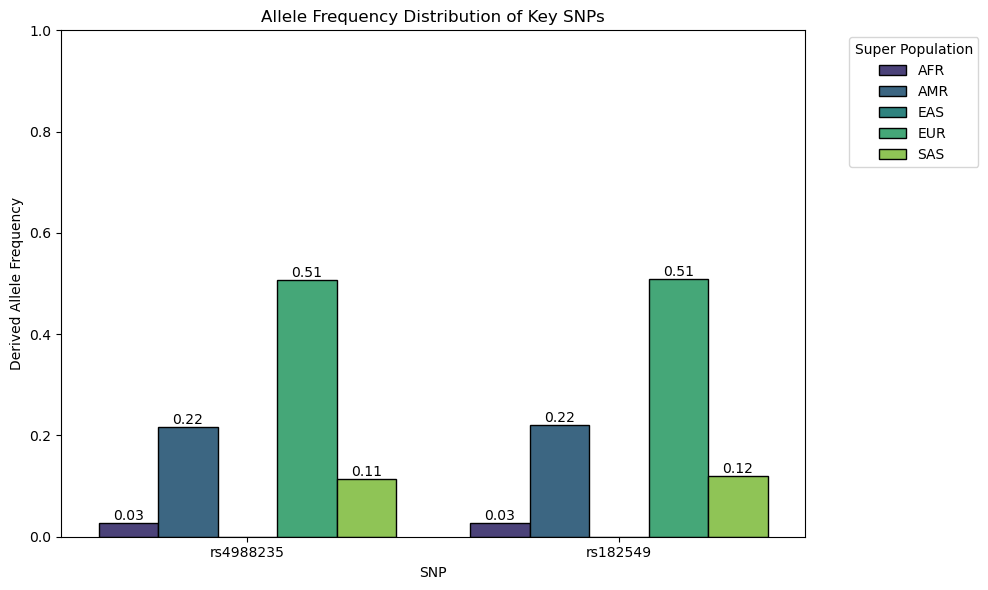

In [ ]:
# =======================================================================
# Figure 3: Allele Frequency Distribution
# =======================================================================
# Define target SNPs (update positions according to your data)
target_snps = {
    'rs4988235': 136608646,   # –13910
    'rs182549':    136616754,
}

# Find SNP indices in the data
snp_indices = []
snp_labels = []
for name, pos in target_snps.items():
    matches = np.where(pos_all == pos)[0]
    if len(matches) > 0:
        snp_indices.append(matches[0])
        snp_labels.append(name)
    else:
        print(f"SNP {name} at position {pos} not found")

if not snp_indices:
    raise ValueError("None of the target SNPs found in the data")

# Get super populations
super_pops = sorted(merged['super_population'].dropna().unique())

# Calculate frequencies for each population
freq_data = []
for snp_idx, snp_name in zip(snp_indices, snp_labels):
    for pop in super_pops:
        # Get sample indices for this population
        pop_samples = merged.index[merged['super_population'] == pop]
        
        # Get all haplotypes for these samples
        hap_cols = []
        for idx in pop_samples:
            hap_cols.extend([2*idx, 2*idx+1])
            
        # Calculate frequency
        derived_count = np.sum(haps_all[snp_idx, hap_cols])
        total_alleles = len(hap_cols)
        freq = derived_count / total_alleles if total_alleles > 0 else 0
        
        freq_data.append({
            'SNP': snp_name,
            'Population': pop,
            'Frequency': freq,
            'TotalAlleles': total_alleles
        })

# Create DataFrame for plotting
df_freq = pd.DataFrame(freq_data)

# Filter populations with sufficient data
df_freq = df_freq[df_freq['TotalAlleles'] > 50]  # Minimum 25 individuals

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_freq,
    x='SNP',
    y='Frequency',
    hue='Population',
    palette='viridis',
    edgecolor='black'
)

# Add frequency labels
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom'
        )

# Formatting
plt.ylim(0, 1)
plt.ylabel('Derived Allele Frequency')
plt.xlabel('SNP')
plt.title('Allele Frequency Distribution of Key SNPs')
plt.legend(
    title='Super Population',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

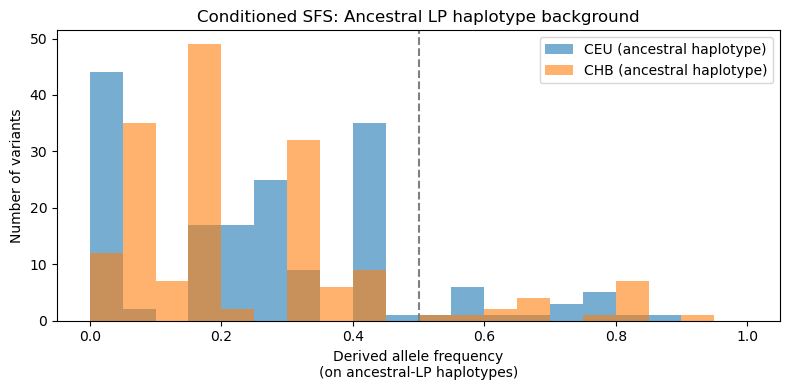

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# ── Assumes in your namespace:
# haps_all: ndarray shape (n_variants, n_haplotypes), values 0/1
# pos_all : ndarray shape (n_variants,), genomic positions
# nw_cols : CEU haplotype indices (0 … 2S-1)
# han_cols: CHB haplotype indices

# 1) Find rs4988235 index
lp_pos = 136608646
lp_idx = np.where(pos_all == lp_pos)[0][0]

# 2) Haplotypes carrying the ancestral allele (0) at that SNP
anc_haps = np.where(haps_all[lp_idx, :] == 0)[0]

# 3) Split by population
anc_ceu = np.intersect1d(anc_haps, nw_cols)
anc_chb = np.intersect1d(anc_haps, han_cols)

# 4) Compute derived‐allele frequencies across all other sites
freq_ceu = haps_all[:, anc_ceu].mean(axis=1)
freq_chb = haps_all[:, anc_chb].mean(axis=1)

# 5) Restrict to polymorphic sites in both groups
mask = (freq_ceu > 0) & (freq_ceu < 1) & (freq_chb > 0) & (freq_chb < 1)

# 6) Plot conditioned SFS
plt.figure(figsize=(8,4))
bins = np.linspace(0,1,21)
plt.hist(freq_ceu[mask], bins=bins, alpha=0.6, label='CEU (ancestral haplotype)')
plt.hist(freq_chb[mask], bins=bins, alpha=0.6, label='CHB (ancestral haplotype)')
plt.axvline(0.5, color='gray', linestyle='--')
plt.xlabel('Derived allele frequency\n(on ancestral‐LP haplotypes)')
plt.ylabel('Number of variants')
plt.title('Conditioned SFS: Ancestral LP haplotype background')
plt.legend()
plt.tight_layout()
plt.show()
